In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import pandas as pd
import ta
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error 
from ta import add_all_ta_features

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from src.visualization.visualize import DisplayTicker
from src.features.build_features import StockTechnicals
from src.models.backtest_strategy import TradeHoldStrategy


# Convert Data Function

The function below will load a CSV file with a start and end date to filter out the time range for testing. 

In addition, for feature selection, I used the following subset features for regression, there were over 85s features in the TA library:

data_df['SMA_20'] = indicator_SMA20.sma_indicator()

data_df['bb_bbm'] = indicator_bb.bollinger_mavg()

data_df['bb_bbh'] = indicator_bb.bollinger_hband()

data_df['bb_bbl'] = indicator_bb.bollinger_lband()

data_df['MACD'] = indicator_MACD.macd()

data_df['MACD signal'] = indicator_MACD.macd_signal()


In [2]:
def convert_data(stock_ticker_csv, start_date, end_date):
    """
    stock_ticker_csv : csv file
    end_date : string
    days_to_backtrack : int
    Takes in a CSV File and converts the date to numbers
    Returns DF with Dates converted to numerical format and the original Dates for plotting
    """

    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
 

    # Load the CSV File
    stock_ticker = pd.read_csv(stock_ticker_csv, index_col=['Date'], parse_dates=['Date'])
    stock_ticker.sort_values('Date')
    stock_ticker = stock_ticker[start_date: end_date]

    stock_ticker.reset_index(inplace=True)
    
    data_df = stock_ticker.copy()
    data_df = data_df.reset_index()
    org_dates = data_df['Date']
    data_df['Pretty Date'] = data_df['Date']
    

    # Converting Dates to Numbers - SVR doesn't work with dates
    data_df['Date'] = data_df['Date'].map(mdates.date2num)

    indicator_bb = ta.volatility.BollingerBands(close=data_df["Close"], n=20, ndev=2)
    indicator_SMA20 = ta.trend.SMAIndicator(close=data_df["Close"],n=20, fillna=True)
    indicator_MACD = ta.trend.MACD(close=data_df["Close"],n_fast=5, n_slow=30, fillna=True)
  
    # Features added to original date
    data_df['SMA_20'] = indicator_SMA20.sma_indicator()
    data_df['bb_bbm'] = indicator_bb.bollinger_mavg()
    data_df['bb_bbh'] = indicator_bb.bollinger_hband()
    data_df['bb_bbl'] = indicator_bb.bollinger_lband()
    data_df['MACD'] = indicator_MACD.macd()
    data_df['MACD signal'] = indicator_MACD.macd_signal()
 
    # Return DF with Dates converted to numerical format and the original Dates for plotting
    return data_df, org_dates




In [3]:


def svc_param_selection(X, y, nfolds, model):
    Cs = [10, 100, 1000, 10000, 100000]
    gammas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVR(kernel=model), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_

    return grid_search.best_params_

# Model Training and Prediction Function

This function takes the ticker dataframe, forecasted number of dates (5 in this case), and tries to predict a price based on the best parameters.

In [4]:
def predict_multiple_variables(ticker_df, dates_org, num_forecast_days, C_user=None, G_user=None, model =  'rbf'):

    features=['Date','SMA_20','Open','Volume', 'bb_bbl', 'MACD']
    num_training_days = len(ticker_df)
    days_to_predict = dates_org[-num_forecast_days:].dt.date
    print("=" * 100)
    print("Predicting values for the following dates: ")
    for d in days_to_predict:
        print(f'{d}')
    print("=" * 100)
    #print(f'{type(dates_org[-num_forecast_days:])}')
    #print(f'{type(dates_org[-num_forecast_days:].values)}')
    
    #print(dates_org[-num_forecast_days:])
    train_x = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][features]
    # Seperate Predicted variable
    train_y = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][['Close']]

     # Split off test days for forecasting
    test_x = ticker_df[-num_forecast_days:][features]
    test_y = ticker_df[-num_forecast_days:][['Close']]
    
    best_params = svc_param_selection(train_x, train_y.values.reshape(-1,), 3, model=model)

    if C_user is None or G_user is None:
        C_user = best_params["C"]
        G_user = best_params["gamma"]
        print(f'Using Grid Search Values C {C_user} and gamma {G_user} values')
    else:
        print(f'Using user provided C {C_user} and gamma {G_user} values')

    # Fit training data using SVR/RBF
    svr_rbf = SVR(kernel= model, C=C_user, gamma= G_user)
    
    svr_rbf.fit(train_x, train_y.values.reshape(-1,))

    
    
    y_pred = svr_rbf.predict(test_x)
    print("=" * 100)
    print("Predicted Values: {}".format(y_pred))
    print("-" * 100)
    print(f"Actual Values: {np.squeeze(test_y.values)}")
    print("-" * 100)
    print(f"Model Score: {svr_rbf.score(train_x, train_y)}")
    print("-" * 100)
    print(f"Model R2 Score: {r2_score(test_y, y_pred)}")
    print("-" * 100)
    print(f"Mean Squared Error (MSE): {mean_squared_error(test_y, y_pred)}")
    print("-" * 100)
    print(f"RMSE: {np.sqrt(mean_squared_error(test_y, y_pred))}")
    print("=" * 100)

    plt.figure(figsize = (12,6))
    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        svr_rbf.predict(train_x), 
                        color= 'red', label= 'Train Data')

    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        train_y , 
                        color= 'black', 
                        label= 'Actual Data')
    plt.legend()
    plt.show()

    plt.figure(figsize = (12,6))

    ax = plt.gca()
    formatter = mdates.DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.DayLocator()
    ax.xaxis.set_major_locator(locator)
    
    #print("xmin: {}".format(num_forecast_days:num_forecast_days+1 ))
    # if the forecast is one day, it will not plot a line

    if num_forecast_days == 1:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:], xmax=ticker_df['Pretty Date'][-1:])
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], svr_rbf.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')

    # Otherwise, plot a line for x > 1
    
    else:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:-num_forecast_days+1], xmax=ticker_df['Pretty Date'][-1:])
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], svr_rbf.predict(test_x), 
                        color= 'green', 
                        label= 'Predicted Data')
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'black', 
                        label= 'Actual')
    
    #print("X max: {}, X Min: {}".format(xmax, xmin))
    plt.legend()
    plt.show()

    



In [5]:
def corr_plot(df):
    corrMatrix = df.drop(columns=['index','Date','Pretty Date']).corr()
    print(corrMatrix.shape)
    import seaborn as sn
    sn.heatmap(corrMatrix, 
            annot=True, 
            vmin = -1, 
            vmax=1, 
            center=0,
            fmt='.2g',
            linewidths=10,
            annot_kws={"size": 8},
            cbar_kws={"shrink": 1.0},
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True)
    plt.figure(figsize = (125,125))
    plt.show()


# Predicting Microsoft Stock Prices

SVR fails to predict well with the training data. The prediction numbers are off quite a bit, even with day 1. In looking at the chart below, it is obvious that the model appears to be overfitting and therefore cannot take properly deal with unseen data.

# Date Selection

For data selection, I choose to use 2019. as a training year to test how well SVR would perform. This helped test a few scenarios for the data. 

In [6]:
start_date = '2019-10-31'
end_date = '2019-12-31'
MSFT, MSFT_dates = convert_data('./.data/MSFT.csv',start_date, end_date)
AAPL, AAPL_dates = convert_data('./.data/AAPL.csv',start_date, end_date)
AMZN, AMZN_dates = convert_data('./.data/AMZN.csv',start_date, end_date)
GOOG, GOOG_dates = convert_data('./.data/GOOG.csv',start_date, end_date)
_GSPC, _GSPC_dates = convert_data('./.data/_GSPC.csv',start_date, end_date)

# Correlation Matrix based for Microsoft

The correlation matrix is printed below to show how much these values move together in the same/opposite direction

(12, 12)


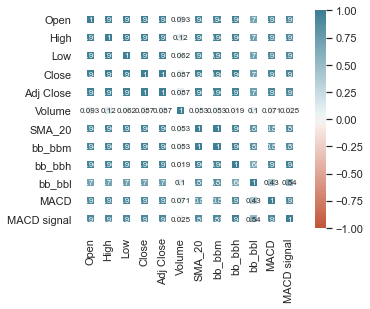

<Figure size 9000x9000 with 0 Axes>

In [7]:
corr_plot(MSFT)

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 100 and gamma 0.009 values
Predicted Values: [150.07702751 150.07702751 150.07702751 150.07702751 150.07702751]
----------------------------------------------------------------------------------------------------
Actual Values: [157.380005 158.669998 158.960007 157.589996 157.699997]
----------------------------------------------------------------------------------------------------
Model Score: 0.9993038795850729
----------------------------------------------------------------------------------------------------
Model R2 Score: -159.71820265501123
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 64.12686115558738
----------------------------------------------------------------------------------------------------
RMSE: 8.007924896974707


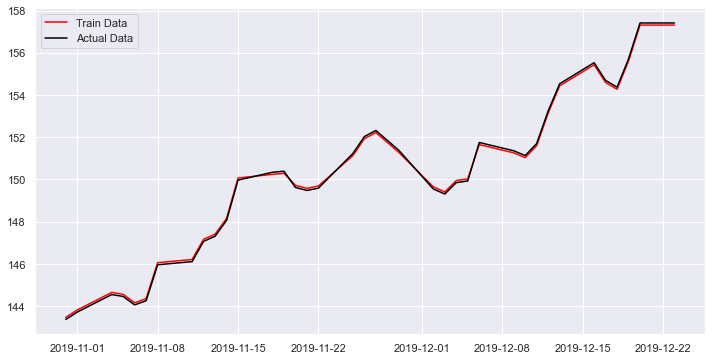

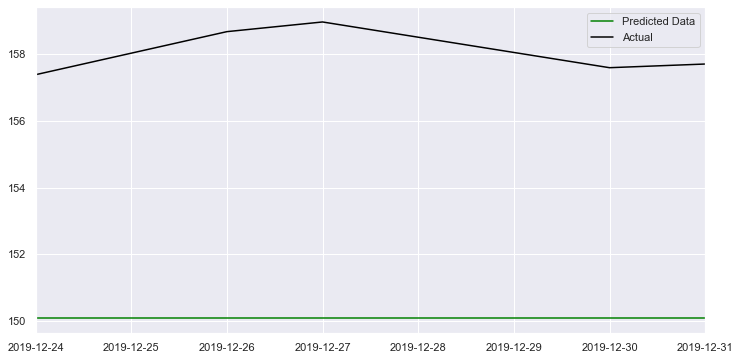

In [8]:
predict_multiple_variables(MSFT,MSFT_dates,num_forecast_days=5, C_user= 100, G_user=.009, model = 'rbf')


# Predicting Apple Stock Prices

# Correlation Matrix based for Apple

The correlation matrix is printed below to show how much these values move together in the same/opposite direction

(12, 12)


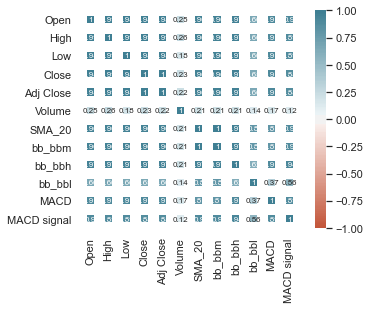

<Figure size 9000x9000 with 0 Axes>

In [9]:
corr_plot(AAPL)

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using Grid Search Values C 10 and gamma 1e-05 values
Predicted Values: [265.85413921 265.85413921 265.85413921 265.85413921 265.85413921]
----------------------------------------------------------------------------------------------------
Actual Values: [284.269989 289.910004 289.799988 291.519989 293.649994]
----------------------------------------------------------------------------------------------------
Model Score: 0.9140000977308315
----------------------------------------------------------------------------------------------------
Model R2 Score: -59.42197673490791
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 584.5154436499648
----------------------------------------------------------------------------------------------------
RMSE: 24.176754200056816


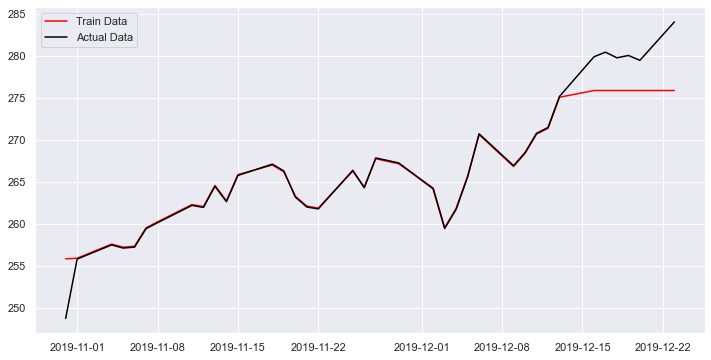

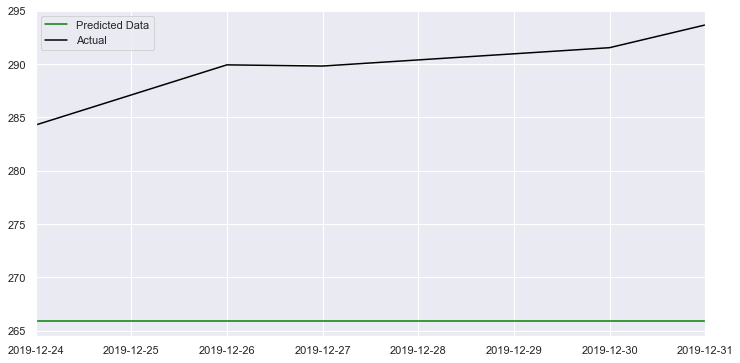

In [10]:
predict_multiple_variables(AAPL,AAPL_dates,num_forecast_days=5, model='rbf')


# Predicting Amazon Stock Prices

# Correlation Matrix based for Amazon

The correlation matrix is printed below to show how much these values move together in the same/opposite direction

(12, 12)


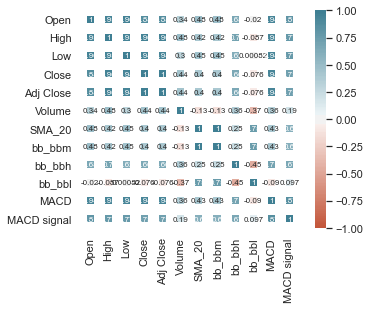

<Figure size 9000x9000 with 0 Axes>

In [11]:
corr_plot(AMZN)

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 100 and gamma 0.009 values
Predicted Values: [1771.38269303 1771.38269303 1771.38269303 1771.38269303 1771.38269303]
----------------------------------------------------------------------------------------------------
Actual Values: [1789.209961 1868.77002  1869.800049 1846.890015 1847.839966]
----------------------------------------------------------------------------------------------------
Model Score: 0.9999792426336678
----------------------------------------------------------------------------------------------------
Model R2 Score: -6.21247429908752
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 6207.029831404974
----------------------------------------------------------------------------------------------------
RMSE: 78.78470556780024


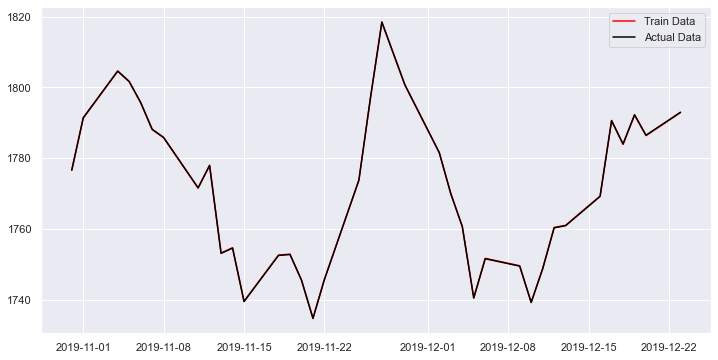

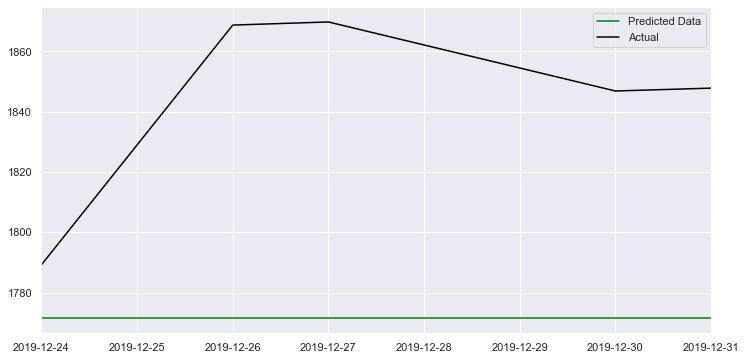

In [12]:
predict_multiple_variables(AMZN,AMZN_dates,num_forecast_days=5, C_user=100, G_user=.009)


# Predicting Google Stock Prices

SVR does a poor job of adapting to unpredicted spikes when

# Correlation Matrix based for Google

The correlation matrix is printed below to show how much these values move together in the same/opposite direction

(12, 12)


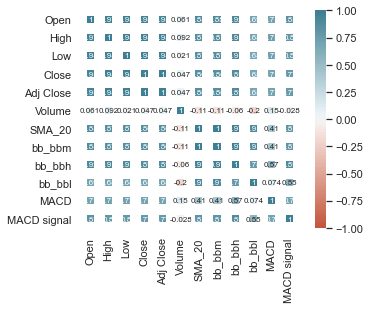

<Figure size 9000x9000 with 0 Axes>

In [13]:
corr_plot(GOOG)

Predicting values for the following dates: 
2019-12-24
2019-12-26
2019-12-27
2019-12-30
2019-12-31
Using user provided C 120 and gamma 0.001 values
Predicted Values: [1318.25407582 1318.25407582 1318.25407582 1318.25407582 1318.25407582]
----------------------------------------------------------------------------------------------------
Actual Values: [1343.560059 1360.400024 1351.890015 1336.140015 1337.02002 ]
----------------------------------------------------------------------------------------------------
Model Score: 0.9999846613179266
----------------------------------------------------------------------------------------------------
Model R2 Score: -8.914067263700225
----------------------------------------------------------------------------------------------------
Mean Squared Error (MSE): 844.0235236104243
----------------------------------------------------------------------------------------------------
RMSE: 29.0520829478787


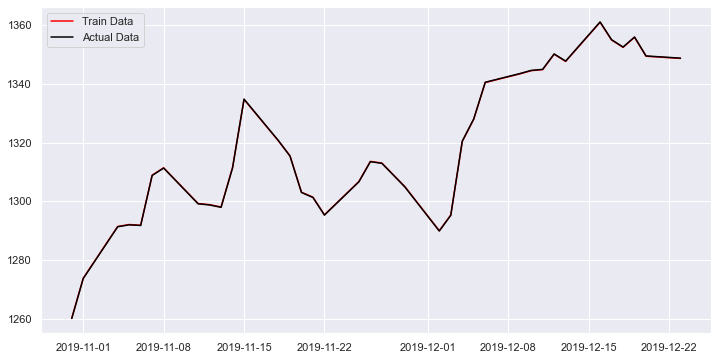

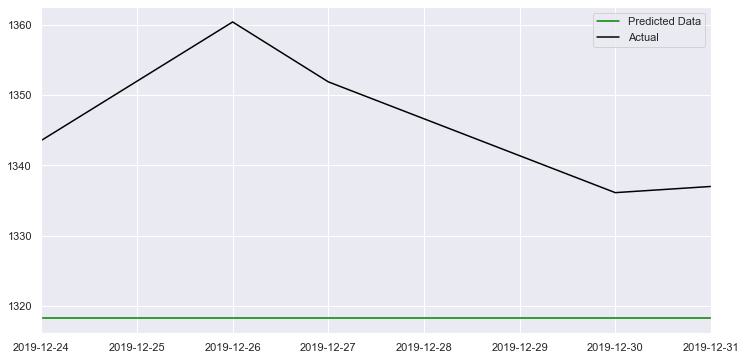

In [14]:
predict_multiple_variables(GOOG, GOOG_dates, num_forecast_days=5, C_user=120, G_user=.001,model =  'rbf')
